In [ ]:
import pandas as pd
from prettytable import PrettyTable
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

#### Liver Cirrhosis Survival Prediction
##### dataset: https://archive.ics.uci.edu/dataset/878/cirrhosis+patient+survival+prediction+dataset-1

Importing the data

In [5]:
# loading
data_path = '/content/cirrhosis 2.csv'
df = pd.read_csv(data_path, verbose=False)
df.dropna(inplace=True) # drop rows including nan

# overview
table = PrettyTable()
table.field_names = ["Features","Unique Values"]
for i in list(df.columns) :
    nunique =df[str(i)].nunique
    table.add_row([i, f"{nunique()}"])
print('Unique values in original dataset : \n')
print(table)

Unique values in original dataset : 

+---------------+---------------+
|    Features   | Unique Values |
+---------------+---------------+
|       ID      |      276      |
|     N_Days    |      267      |
|     Status    |       3       |
|      Drug     |       2       |
|      Age      |      275      |
|      Sex      |       2       |
|    Ascites    |       2       |
|  Hepatomegaly |       2       |
|    Spiders    |       2       |
|     Edema     |       3       |
|   Bilirubin   |       82      |
|  Cholesterol  |      198      |
|    Albumin    |      125      |
|     Copper    |      152      |
|    Alk_Phos   |      269      |
|      SGOT     |      166      |
| Tryglicerides |      143      |
|   Platelets   |      193      |
|  Prothrombin  |       41      |
|     Stage     |       4       |
+---------------+---------------+


Lets have a look at distribution of some features

<Axes: >

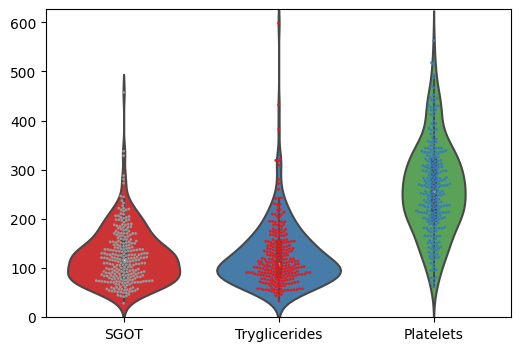

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
order = ['SGOT', 'Tryglicerides', 'Platelets']
sns.violinplot(data=df, order=order, palette='Set1', saturation=0.75, alpha=0.3, ax=ax)
sns.swarmplot(data=df, order=order, palette='Set1', size=2, ax=ax)

Feature Engineering

In [15]:
# adding new feature "Age_in_year"
def convert_days_to_years(age_in_days):
    days_in_year = 365.25
    age_in_years = age_in_days / days_in_year
    return age_in_years

def add_cols(df):
    age = list(df.Age)
    age_in_year = []
    for i in age :
        age_in_year.append(int(convert_days_to_years(i)))
    df['Age_in_year'] = pd.Series(age_in_year)
    return df

df = add_cols(df)

# thrombocytopenia Indicator: Presence (1) indicates thrombocytopenia and Absence (0) denotes normal platelet levels.
threshold_platelets = 150
df['thrombocytopenia'] = np.where(df['Platelets'] < threshold_platelets, 1, 0)

# elevated Alkaline Phosphatase Indicator
threshold_alk_phos_upper = 147  # Upper limit of normal range
threshold_alk_phos_lower = 44   # Lower limit of normal range
df['elevated_alk_phos'] = np.where((df['Alk_Phos'] > threshold_alk_phos_upper) | (df['Alk_Phos'] < threshold_alk_phos_lower), 1, 0)

# normal copper levels
normal_copper_range = (62, 140)
df['normal_copper'] = np.where((df['Copper'] >= normal_copper_range[0]) & (df['Copper'] <= normal_copper_range[1]), 1, 0)

# normal albumin range
normal_albumin_range = (3.4, 5.4)
df['normal_albumin'] = np.where((df['Albumin'] >= normal_albumin_range[0]) & (df['Albumin'] <= normal_albumin_range[1]), 1, 0)

# Normal bilirubin levels
normal_bilirubin_range = (0.2, 1.2)
df['normal_bilirubin'] = np.where((df['Bilirubin'] >= normal_bilirubin_range[0]) & (df['Bilirubin'] <= normal_bilirubin_range[1]), 1, 0)

<Axes: >

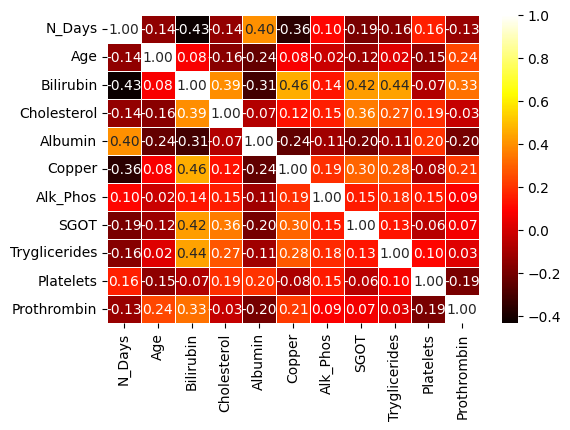

In [16]:
# selecting numeric columns to scale the data
numeric_cols= ['N_Days',  'Age',  'Bilirubin', 'Cholesterol',
                'Albumin', 'Copper', 'Alk_Phos', 'SGOT',
                'Tryglicerides', 'Platelets', 'Prothrombin']
df_to_scale = df[numeric_cols]

correlation_matrix = df_to_scale.corr()

# Create a heatmap with masked upper triangle
fig, ax = plt.subplots(1, 1, figsize=(6,4))
sns.heatmap(correlation_matrix, annot=True, cmap='hot', fmt='.2f', linewidths=.5, ax=ax)

Scaling the data

In [17]:
# scaling the numerical columns
sc = MinMaxScaler()
df_scaled = pd.DataFrame(sc.fit_transform(df_to_scale), columns = df_to_scale.columns)

# selecting only categorical columns
df_cat = df.drop(numeric_cols, axis =1)
df_1 = df_cat[['ID','Age_in_year','Status']]
df_cat = df_cat.drop(['ID','Age_in_year','Status'], axis=1)

# encoding the categorical columns
df_cat_1 = pd.get_dummies(df_cat, columns=df_cat.columns)
df_cat_1 = df_cat_1.replace({True: 1, False: 0})

# join the scaled and encoded columns
df_merged = pd.concat([df_cat_1, df_scaled, df_1], axis=1)
df_merged['Status'] = df_merged['Status'].replace({'C': 0, 'D': 1, 'CL': 2})
df_merged.dropna(inplace=True)

Classification with Random forest

accuracy of the model checked with test data: 0.9452054794520548


Text(20.72222222222222, 0.5, 'Actual')

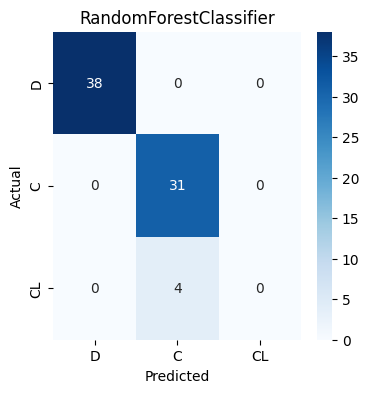

In [19]:
X = df_merged
y = df_merged['Status']

# Label encode target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# split to train and test, cross validation, and classification with RF
model = RandomForestClassifier(n_estimators=100)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, train_size=0.7,
                                                    test_size=0.3, shuffle=True,
                                                    random_state=42)

# n_scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=10, n_jobs=-1)
model.fit(X_train, y_train)

# reporting and features overview
importance = model.feature_importances_
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'accuracy of the model checked with test data: {accuracy}')
conf_matrix = confusion_matrix(y_test, y_pred)

# plotting confusion matrix
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['D', 'C', 'CL'], yticklabels=['D', 'C', 'CL'],
            ax=ax)
ax.set_title(type(model).__name__)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

Feature Importance

Text(0.5, 1.0, 'Feature Importance')

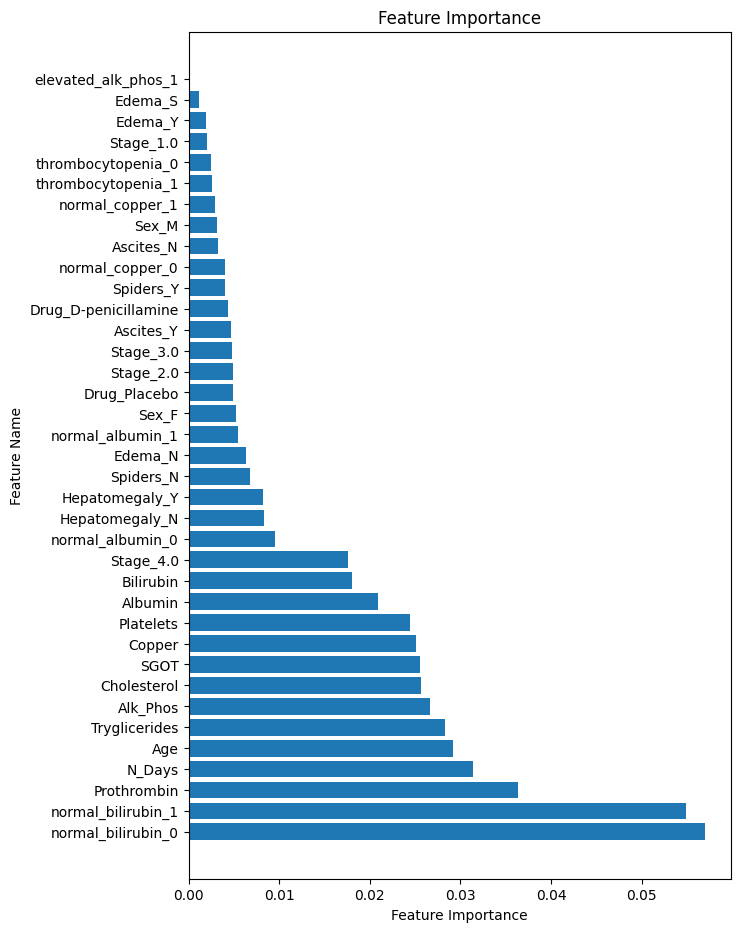

In [20]:
feature_importances = model.feature_importances_
feature_names = df_merged.columns[:-3]
feature_importance_dict = dict(zip(feature_names, feature_importances))
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
sorted_feature_names, sorted_importance_scores = zip(*sorted_feature_importance)

fig, ax = plt.subplots(1, 1, figsize=(7, 11))
ax.barh(sorted_feature_names, sorted_importance_scores)
ax.set_xlabel("Feature Importance")
ax.set_ylabel("Feature Name")
ax.set_title("Feature Importance")
